In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from probml_utils import latexify, savefig
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig

try:
    from tinygp import GaussianProcess, kernels
except ModuleNotFoundError:
    %pip install -qqq tinygp
    from tinygp import GaussianProcess, kernels

jax.config.update("jax_enable_x64", True)

In [3]:
latexify(width_scale_factor=3, fig_height=1.5)

/usr/local/lib/python3.12/dist-packages/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [4]:
c_0 = "#1f77b4"
c_1 = "#ff7f0e"

## Samples from prior (noiseless & noisy)

/usr/local/lib/python3.12/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


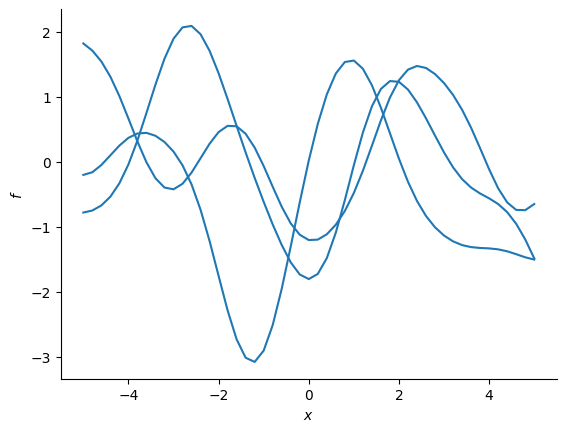

In [5]:
def sample_from_prior(key, data, save_name):
    kernel = kernels.ExpSquared(scale=1.0)
    gp = GaussianProcess(kernel, data["x"], diag=1e-8 + data["noise"])
    samples = gp.sample(key, shape=(data["n_samples"],))

    plt.figure()
    plt.plot(x, samples.T, color=c_0)
    plt.xlabel("$x$")
    plt.ylabel("$f$")
    #     plt.legend(["samples"], loc="lower left")
    sns.despine()
    if len(save_name) > 0:
        savefig(save_name)


key = jax.random.PRNGKey(0)
x = jnp.arange(-5, 5.2, 0.2)

data = {"noise": 0.0, "n_samples": 3, "x": x}
sample_from_prior(key, data, "gprDemoNoiseFreePrior")

## Samples from posterior (noiseless & noisy)

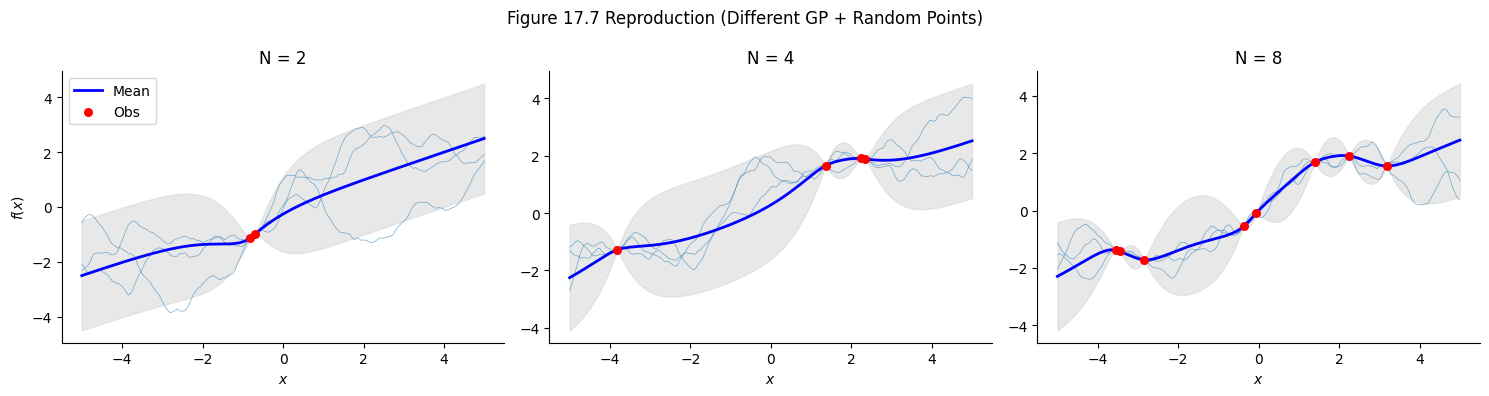

In [6]:
def mean_fn(x):
    return 0.5 * x

def sample_from_posterior_modified(key, n_obs, ax):

    k1, k2 = jax.random.split(key)

    x_train = jax.random.uniform(k1, shape=(n_obs,), minval=-4.0, maxval=4.0)

    y_train = mean_fn(x_train) + jnp.sin(x_train)


    x_test = jnp.linspace(-5, 5, 200)

    kernel = kernels.Matern32(scale=1.0)

    gp = GaussianProcess(kernel, x_train, diag=1e-8, mean=mean_fn)

    cond_gp = gp.condition(y_train, x_test).gp

    samples = cond_gp.sample(k2, shape=(3,))
    mean = cond_gp.mean
    std = jnp.sqrt(cond_gp.variance)


    ax.plot(x_test, samples.T, color=c_0, lw=0.5, alpha=0.6)
    ax.plot(x_test, mean, color="blue", lw=2, label="Mean")
    ax.scatter(x_train, y_train, color="red", zorder=10, s=30, label="Obs")
    ax.fill_between(x_test, mean - 2 * std, mean + 2 * std, color="lightgray", alpha=0.5)

    ax.set_title(f"N = {n_obs}")
    ax.set_xlabel("$x$")
    if n_obs == 2:
        ax.set_ylabel("$f(x)$")
        ax.legend()
    sns.despine()

key = jax.random.PRNGKey(42)
keys = jax.random.split(key, 3)
n_list = [2, 4, 8]

plt.figure(figsize=(15, 4))
for i, n in enumerate(n_list):
    ax = plt.subplot(1, 3, i+1)
    sample_from_posterior_modified(keys[i], n, ax)

plt.suptitle("Figure 17.7 Reproduction (Different GP + Random Points)")
plt.tight_layout()
plt.show()

## Demo (variable noise)

In [ ]:
from ipywidgets import interact


@interact(random_state=(1, 10), noise=(0.0, 0.2, 0.01))
def animate_gp_regression(random_state=0, noise=0):
    key = jax.random.PRNGKey(random_state)
    data = {"noise": noise, "n_samples": 3, "x_train": x_train, "y_train": y_train, "x_test": x_test}
    sample_from_posterior_modified(key, data, "")
    plt.title(f"noise: {noise}, random_state: {random_state}")